In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
from scipy import integrate
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)
import timeit


from deep_bayes.models import DeepEvidentialModel, MCDropOutModel, SoftmaxModel, VAE
from deep_bayes.settings import EVIDENTIAL_TUMOR, SOFTMAX_TUMOR, VAE_TUMOR, DROPOUT_TUMOR
from deep_bayes.training import train_online, train_online_vae, train_online_dropout, train_online_softmax
from deep_bayes.losses import log_loss
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\tensorflow\python\framework\dtypes.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tf.enable_eager_execution()

In [4]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [5]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [6]:
def generalized_logistic_params_prior(**args):
    """
    Samples from the prior of the Holling Type II model theta = (alpha, mu, gamma, g, h, sigma0, sigma1, init0, init1)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(0.001, 5),                # alpha
        np.random.randint(low=10**3, high=10**6+1), # K
        np.random.uniform(1, 3),                    # gamma
        np.random.uniform(0.1, 1000),               # mu     
        np.random.uniform(0, 1000),                 # a
        np.random.uniform(0.001, 100)               # lambda 
    ])
    
    return theta


def gompertz_params_prior(**args):
    """
    Samples from the prior of the Holling Type II model theta = (alpha, mu, gamma, g, h, sigma0, sigma1, init0, init1)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(0.001, 5),                # alpha
        np.random.randint(low=10**3, high=10**6+1), # K
        np.random.uniform(0.1, 1000),               # mu     
        np.random.uniform(0, 1000),                 # a
        np.random.uniform(0.001, 100)               # lambda 
    ])
    
    return theta


def exponential_params_prior(**args):
    """
    Samples from the prior of the Holling Type II model theta = (alpha, mu, gamma, g, h, sigma0, sigma1, init0, init1)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.array([
        np.random.uniform(0.001, 5),                # alpha
        np.random.uniform(0.1, 1000),               # mu     
        np.random.uniform(0, 1000),                 # a
        np.random.uniform(0.001, 100)               # lambda 
    ])
    
    return theta

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|\boldsymbol{\theta},\boldsymbol{m}).$

In [7]:
def generalized_logistic_model(params, n_obs, **args):
    """
    Generates data from the generalized logistic model.
    """
    
    # Extract params
    alpha, K, gamma, mu, a, lambd = params
    
    # Implement ODEs
    def model(z, t):
        """Differential for number of cancer cells."""
        
        N, Q = z
        dN_dt = (alpha / gamma) * N * ( (1 - (N / K))**gamma) - ( (mu * N * Q) / (a + N))
        dQ_dt = -lambd * Q
        return [dN_dt, dQ_dt]
        
    
    # Initial condition drug mass and cell numbers
    Q0 = 5.4352
    N0 = 100
    t = np.linspace(0, 1, n_obs)
    
    # Solve for N and Q
    nq = integrate.odeint(model, [N0, Q0], t)
    
    # Scale N
    nq[:, 0] /= 1000.
    
    return nq

def gompertz_model(params, n_obs, **args):
    """
    Generates data from the generalized logistic model.
    """
    
    # Extract params
    alpha, K, mu, a, lambd = params
    
    # Implement ODEs
    def model(z, t):
        """Differential for number of cancer cells."""
        
        N, Q = z
        dN_dt = alpha * N * np.log(K / N + 1e-15) - ( (mu * N * Q) / (a + N) )
        dQ_dt = -lambd * Q
        return [dN_dt, dQ_dt]
        
    
    # Initial condition drug mass and cell numbers
    Q0 = 5.4352
    N0 = 100
    t = np.linspace(0, 1, n_obs)
    
    # Solve for N and Q
    nq = integrate.odeint(model, [N0, Q0], t)
    
    # Scale N
    nq[:, 0] /= 1000.
    
    return nq


def exponential_model(params, n_obs, **args):
    """
    Generates data from the generalized logistic model.
    """
    
    # Extract params
    alpha, mu, a, lambd = params
    
    # Implement ODEs
    def model(z, t):
        """Differential for number of cancer cells."""
        
        N, Q = z
        dN_dt = alpha * N  - ( (mu * N * Q) / (a + N) ) 
        dQ_dt = -lambd * Q
        return [dN_dt, dQ_dt]
        
    
    # Initial condition drug mass and cell numbers
    Q0 = 5.4352
    N0 = 100
    t = np.linspace(0, 1, n_obs)
    
    # Solve for N and Q
    nq = integrate.odeint(model, [N0, Q0], t)
    
    # Scale N
    nq[:, 0] /= 1000.
    
    return nq

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [8]:
def data_generator(batch_size, model_prior, param_priors, forward_models, 
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Nan check
    x = tf.where(tf.is_nan(x), -tf.ones_like(x, tf.float32), x)
    
    # Inf check
    x = tf.where(tf.is_inf(x), -2. * tf.ones_like(x, dtype=tf.float32), x)

    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Training hyperparameters

In [9]:
#--- Training hyperparameters ---#
ckpt_file = "tumor_model_selection"
batch_size = 128
epochs = 30
iterations_per_epoch = 1000
n_obs = 100
n_test = 500


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = ['Logistic', 'Gompertz', 'Exponential']
param_priors = [generalized_logistic_params_prior, gompertz_params_prior, exponential_params_prior]
forward_models = [generalized_logistic_model, gompertz_model, exponential_model]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

## Create test data

In [10]:
%%time
test_data = data_gen(n_test)

Wall time: 1.98 s


## Create model

In [19]:
model = DeepEvidentialModel(EVIDENTIAL_TUMOR)

## Compile model
<p>In other words, run and plot performance of untrained networks.</p>

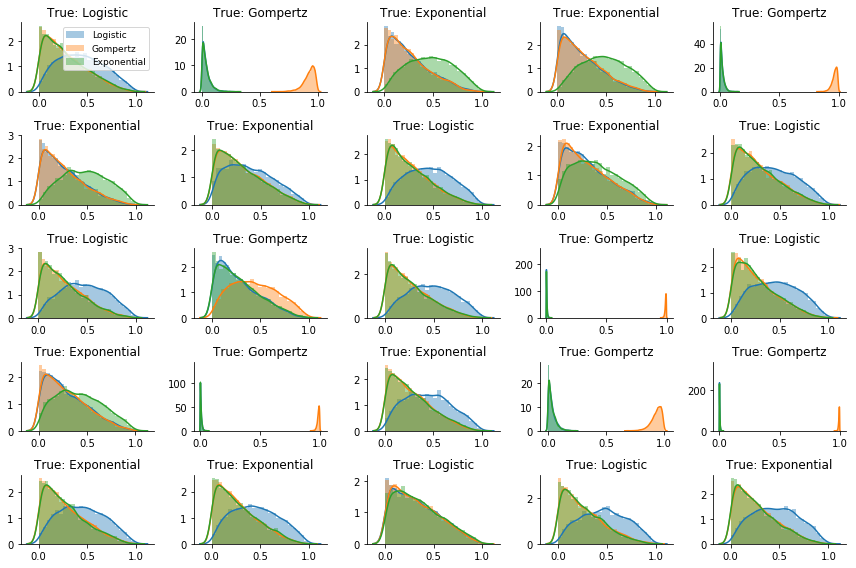

In [18]:
plot_model_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

## Manage checkpoints

In [20]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


# Train network

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log


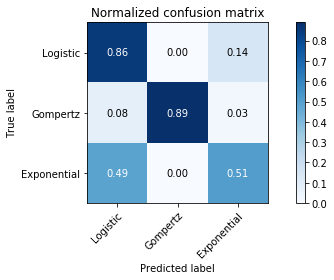

0.764



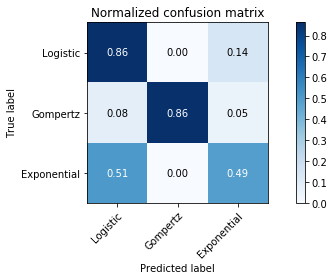

0.75



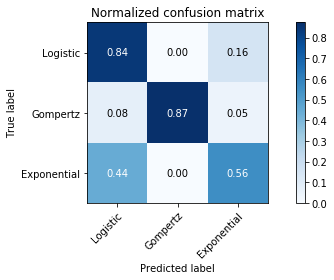

0.768
Instructions for updating:
Use standard file APIs to delete files with this prefix.



KeyboardInterrupt: 

In [21]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence',
                              clip_method='value')
        
        # Plot stuff
        m_pred = model(test_data['x'])['m_probs']
        plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)
        print(accuracy(test_data['m'], m_pred))

        # Store checkpoint
        manager.save()

# ABC

# Validate evidential network

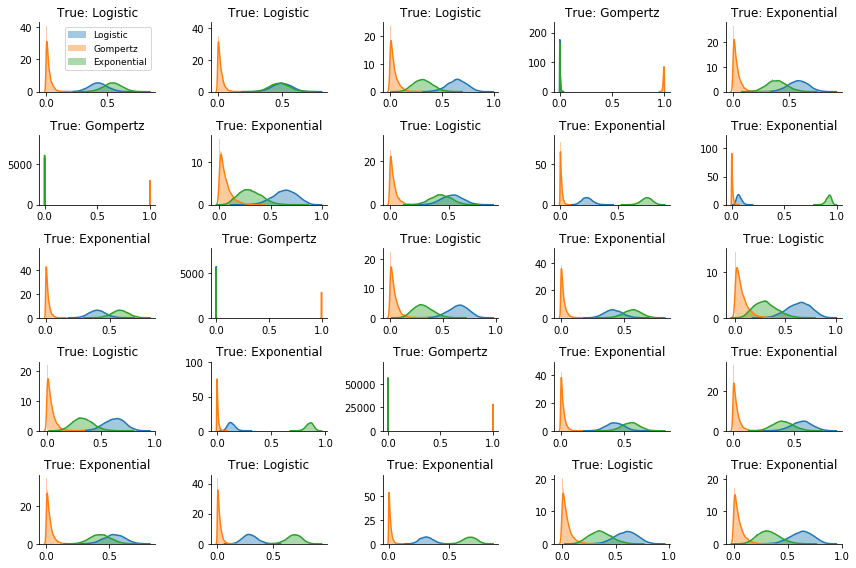

In [38]:
plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

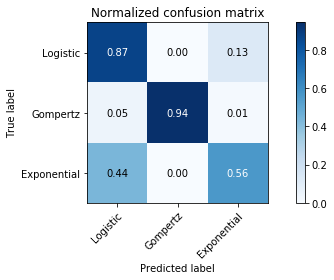

In [39]:
plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, figsize=(8,4), normalize=True)

In [40]:
m_pred = model(test_data['x'])['m_probs']
print(accuracy(test_data['m'], m_pred))

0.7766666666666666


# Compare with other methods

## Hyperparameters

In [23]:
#--- Training hyperparameters ---#
ckpt_file = "tumor_model_selection"
batch_size = 128
epochs = 1
iterations_per_epoch = 10
alpha_smooth=None
n_obs_min = 20
n_obs_max = 200
n_test = 500
starter_learning_rate = 0.0001
decay_steps = 1000
decay_rate = .99

## Competitor models

In [24]:
# Competitor models
models = {
    'evidential': {
        'model': DeepEvidentialModel(EVIDENTIAL_TUMOR),
        'checkpoint': 'tumor_model_selection_evidential',
        'train_fn': partial(train_online, loss_fun=log_loss, method='evidence')
    },
    
    'softmax': {
        'model': SoftmaxModel(SOFTMAX_TUMOR),
        'checkpoint': "tumor_model_selection_softmax",
        'train_fn': train_online_softmax
    },
    
    'dropout': {
        'model': MCDropOutModel(DROPOUT_TUMOR),
        'checkpoint': 'tumor_model_selection_dropout',
        'train_fn': train_online_dropout
    },
    
    'infovae': {
        'model': VAE(VAE_TUMOR),
        'checkpoint': "tumor_model_selection_infovae",
        'train_fn': partial(train_online_vae, regularization='MMD', regularization_weight=0.1)
    },
    
    'vae': {
        'model': VAE(VAE_TUMOR),
        'checkpoint': "tumor_model_selection_vae",
        'train_fn': partial(train_online_vae, regularization='KL', regularization_weight=0.1)
    }
}

## Data generators

In [25]:
#--- Generative model hyperparameters ---#
model_names = ['Logistic', 'Gompertz', 'Exponential']

param_priors = [generalized_logistic_params_prior, 
                gompertz_params_prior, 
                exponential_params_prior]

forward_models = [generalized_logistic_model, 
                  gompertz_model, 
                  exponential_model]

data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   alpha_smooth=alpha_smooth,
                   n_obs_min=n_obs_min,
                   n_obs_max=n_obs_max)

## Train all models

In [28]:
times = []

# Train all models
for model_name, model in models.items():
    
    
    # Create optimizer
    global_step = tfe.Variable(0, dtype=tf.int32)
    learning_rate = tf.train.exponential_decay(starter_learning_rate,
                                               global_step, decay_steps, decay_rate, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Create checkpoint manager
    checkpoint = tf.train.Checkpoint(step=global_step, 
                                     optimizer=optimizer, 
                                     net=model['model'])
    manager = tf.train.CheckpointManager(checkpoint, 
                                         './checkpoints/{}'.format(model['checkpoint']), 
                                         max_to_keep=2)
    
    start = timeit.default_timer()
    # Loop for each epoch
    for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='{}, Training epoch {}'.format(model_name.capitalize(), ep)) as p_bar:
            losses = model['train_fn'](model=model['model'], 
                                       optimizer=optimizer, 
                                       data_gen=data_gen, 
                                       iterations=iterations_per_epoch,
                                       batch_size=batch_size,
                                       p_bar=p_bar,
                                       global_step=global_step)
            manager.save()
            
    stop = timeit.default_timer()
    times.append(stop - start)